In [1]:
# Import necessary packages
# General purpose and visualisation packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import seaborn as sn
import math
import tqdm
import gc
# For neural network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, normalize
# For gene selection
import CorrelationMetrics
from scipy.stats import ks_2samp
from functools import reduce
import random
import os
from numpy.linalg import norm

In [2]:
# Number of rhythmic genes to select

N_GENES = 50
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Load training, validation, test datasets

df = pd.read_csv('Data//X_train_raw.csv').T
df_valid = pd.read_csv('Data//X_valid_raw.csv').T
df_test = pd.concat((pd.read_csv('Data//X_test_raw_A.txt').T, pd.read_csv('Data//X_test_raw_B.txt').T)).iloc[[0, 1, 2, 4, 5], :]
rach_clusters = pd.read_csv('Data//X_train_clusters.csv')
Y_data = df.iloc[1:, -1].astype('float64')
Y_copy = Y_data
Y_valid_data = df_valid.iloc[1:, -1].astype('float64')
Y_valid_copy = Y_valid_data

# Select genes present in all three datasets

common_IDs = reduce(np.intersect1d, (df.iloc[0, :-1].values, df_valid.iloc[0, :-1].values, df_test.iloc[0, :].values))

idx = np.where(df.iloc[0, :].isin(common_IDs))[0]
df = df.iloc[:, idx]
idx_valid = np.where(df_valid.iloc[0, :].isin(common_IDs))[0]
df_valid = df_valid.iloc[:, idx_valid]
idx_test = np.where(df_test.iloc[0, :].isin(common_IDs))[0]
df_test = df_test.iloc[:, idx_test]

X_data = df.iloc[1:, :].astype('float64')
X_ID = df.iloc[0, :]
X_valid_data = df_valid.iloc[1:, :].astype('float64')
X_valid_ID = df_valid.iloc[0, :]
X_test_data = df_test.iloc[1:, :].astype('float64')
X_test_ID = df_test.iloc[0, :]

X_ID1 = np.argsort(X_ID)
X_ID = X_ID.iloc[X_ID1]
X_data = X_data.iloc[:, X_ID1]
X_data.columns = X_ID
X_ID1 = np.argsort(X_valid_ID)
X_valid_ID = X_valid_ID.iloc[X_ID1]
X_valid_data = X_valid_data.iloc[:, X_ID1]
X_valid_data.columns = X_valid_ID
X_ID1 = np.argsort(X_test_ID)
X_test_ID = X_test_ID.iloc[X_ID1]
X_test_data = X_test_data.iloc[:, X_ID1]
X_test_data.columns = X_test_ID

In [3]:
# Variance threshold
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold()
selector.fit(X_data)
var_idx = selector.variances_ > 8
X_data = X_data.iloc[:, var_idx]
X_ID = X_ID.iloc[var_idx]
X_valid_data = X_valid_data.iloc[:, var_idx]
X_valid_ID = X_valid_ID.iloc[var_idx]
X_test_data = X_test_data.iloc[:, var_idx]
X_test_ID = X_test_ID.iloc[var_idx]

X_data.reset_index(inplace=True, drop=True)
X_valid_data.reset_index(inplace=True, drop=True)
X_test_data.reset_index(inplace=True, drop=True)

X_ID.reset_index(inplace=True, drop=True)
X_valid_ID.reset_index(inplace=True, drop=True)
X_test_ID.reset_index(inplace=True, drop=True)

del df
gc.collect()

n_folds = Y_data.shape[0]
folds = KFold(n_splits=n_folds, random_state=SEED)

# Transform time onto the unit circle to enable cyclical loss function

y_cos = -np.cos((2 * np.pi * Y_data.astype('float64') / 24)+(np.pi/2))
y_sin = np.sin((2 * np.pi * Y_data.astype('float64') / 24)+(np.pi/2))

Y_valid_cos = -np.cos((2 * np.pi * Y_valid_data.astype('float64') / 24)+(np.pi/2))
Y_valid_sin = np.sin((2 * np.pi * Y_valid_data.astype('float64') / 24)+(np.pi/2))

Y_data = np.concatenate((y_cos.values.reshape(-1, 1), y_sin.values.reshape(-1, 1)), axis=1)
Y_valid_data = np.concatenate((Y_valid_cos.values.reshape(-1, 1), Y_valid_sin.values.reshape(-1, 1)), axis=1)

C:\Users\colmer\Anaconda3\envs\dota\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [4]:
# Define cyclical loss function and metric

def cyclical_loss(y_true, y_pred):
    error = 0
    for i in range(y_pred.shape[0]):
        error += np.arccos((y_true[i, :] @ y_pred[i, :]) / (norm(y_true[i, :]) * norm(y_pred[i, :])))
    return error

def custom_loss(y_true, y_pred):
    return tf.reduce_mean((tf.math.acos(tf.matmul(y_true, tf.transpose(y_pred)) / ((tf.norm(y_true) * tf.norm(y_pred)) + tf.keras.backend.epsilon()))**2))

adam = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, amsgrad=False)


def larger_model():
    # Create model
    model = Sequential()
    model.add(Dense(32, kernel_initializer='normal', activation='relu'))
    model.add(Dense(128, kernel_initializer='normal', activation='relu'))
    model.add(Dense(512, kernel_initializer='normal', activation='relu'))
    model.add(Dense(2, kernel_initializer='normal'))
    # Compile model
    model.compile(loss=custom_loss, optimizer=adam)
    return model

# Initialise error and prediction arrays
error = 0
val_errors1 = []
test_errors1 = []
all_preds = np.zeros((Y_data.shape[0], 2))
all_valid_preds = np.zeros((Y_valid_data.shape[0], 2))
early_stop = EarlyStopping(patience=50, restore_best_weights=True, monitor='val_loss', mode='min')

In [5]:
# Score all genes based on rhythmic metrics
auto_indices, auto_clock_genes, auto_scores = CorrelationMetrics.get_autocorrelated_genes(X_data, X_ID)
auto_scores = np.abs(np.array(auto_scores))

cross_indices, cross_clock_genes, cross_scores = CorrelationMetrics.cross_corr(X_data, Y_copy, X_ID)
cross_scores = np.abs(np.array(cross_scores))

scores = np.concatenate((auto_scores.reshape(-1, 1), cross_scores.reshape(-1, 1)), axis=1)

# Aggregate scores and select highest scoring genes

auto_scores = np.argsort(np.mean(scores, axis=1))
scores1 = np.mean(scores, axis=1)
scores2 = np.concatenate((X_data.columns.values.reshape(-1, 1), scores1.reshape(-1, 1)), axis=1)
auto_indices = auto_scores[-N_GENES*50:]
auto_clock_genes = np.array(auto_clock_genes)
auto_clock_genes = auto_clock_genes[auto_indices]
auto_scores1 = scores1[auto_indices]

idx = np.where(X_ID.isin(auto_clock_genes))[0]
X_data = X_data.iloc[:, idx]
scores2 = scores2[idx]
idx_valid = np.where(X_valid_ID.isin(auto_clock_genes))[0]
X_valid_data = X_valid_data.iloc[:, idx_valid]
idx_test = np.where(X_test_ID.isin(auto_clock_genes))[0]
X_test_data = X_test_data.iloc[:, idx_test]

X_ID = X_ID.iloc[idx]
X_valid_ID = X_valid_ID.iloc[idx_valid]
X_test_ID = X_test_ID.iloc[idx_test]

scores = []
pvalues = []

# Remove genes whose distribution is different between training and validation dataset

for i in range(X_data.shape[1]):
    l = ks_2samp(X_data.iloc[:, i], X_valid_data.iloc[:, i])
    scores.append(i)
    pvalues.append(l.pvalue)

pvalues_idx = np.argsort(pvalues)
scores = pvalues_idx[(pvalues_idx.shape[0]-30*N_GENES):]

similar_genes = auto_clock_genes[scores]
X_data = X_data.iloc[:, scores]
scores2 = scores2[scores]
X_ID = X_ID.iloc[scores]
X_valid_data = X_valid_data.iloc[:, scores]
X_test_data = X_test_data.iloc[:, scores]
auto_scores1 = auto_scores1[scores]

Y_copy_res = np.array([0, 4, 8, 12, 16, 20, 0, 4, 8, 12, 16, 20])

X_ID2 = X_data.columns.values

# Scale expression data before entering neural network

scaler = MinMaxScaler()
scaler.fit(X_data)
X_data = scaler.transform(X_data)
X_valid_data = scaler.transform(X_valid_data)
X_test_data = scaler.transform(X_test_data)

X_data = pd.DataFrame(data=X_data, columns=X_ID2)
X_valid_data = pd.DataFrame(data=X_valid_data, columns=X_ID2)
X_test_data = pd.DataFrame(data=X_test_data, columns=X_ID2)

# Remove genes whose expression level is different between training and validation

column_max = np.max(X_valid_data.values, axis=0)
column_min = np.min(X_valid_data.values, axis=0)
column_idx = column_max < 1.4
column_idx1 = column_min > -0.2
column_idx = np.logical_and(column_idx, column_idx1)
X_data = X_data.iloc[:, column_idx]
scores2 = scores2[column_idx]
X_ID = X_ID.iloc[column_idx]
X_valid_data = X_valid_data.iloc[:, column_idx]
X_test_data = X_test_data.iloc[:, column_idx]
auto_scores1 = auto_scores1[column_idx]

100%|██████████| 9664/9664 [00:03<00:00, 2747.27it/s]


In [6]:
# Primitive method of selecting genes belonging from diverse clusters, sequential method included in separate .py file
score_df = pd.DataFrame(data=scores2, columns=['transcript', 'score'])
cluster_score_df = pd.merge(score_df, rach_clusters, how='left', left_on='transcript', right_on='transcript')

cluster_score_df.fillna(value='None', inplace=True)
print(cluster_score_df['moduleColor'].value_counts())

colours = cluster_score_df['moduleColor'].unique()

results = {'idx': [], 'train_error': [], 'val_error': [], 'test_error': []}
results1 = []
idx_perm = []
graph_res = []

n_genes = 0
i = 0
counter = 0

keep = []

for i in range(colours.shape[0]):
    colour = colours[i]
    genes = cluster_score_df.loc[cluster_score_df['moduleColor'] == colour]
    genes.sort_values(by='score', inplace=True, ascending=False)
    keep.append(genes.index.values[:8])

keep = np.concatenate(keep)
cluster_score_df = cluster_score_df.iloc[keep, :]
X_data = X_data.iloc[:, keep]
X_valid_data = X_valid_data.iloc[:, keep]
X_test_data = X_test_data.iloc[:, keep]

cluster_score_df.reset_index(drop=True, inplace=True)


i = 0

idx = [3, 12, 18, 29, 38, 44, 52, 58, 64, 8, 17, 25, 34, 49, 62]

X_data = X_data.iloc[:, idx]
X_valid_data = X_valid_data.iloc[:, idx]
X_test_data = X_test_data.iloc[:, idx]

X_data = X_data.values
X_valid_data =X_valid_data.values
X_test_data = X_test_data.values
#
valid_preds = []
test_preds = []

# K-fold cross validation fit model on train, predict on valid and test

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_data, Y_data)):
    X_train, Y_train = X_data[train_idx], Y_data[train_idx]  # Define training data for this iteration
    X_valid, Y_valid = X_data[valid_idx], Y_data[valid_idx]

    model = larger_model()
    model.fit(X_train.astype('float64'), Y_train.astype('float64'), validation_data=(X_valid.astype('float64'), Y_valid.astype('float64')),
              batch_size=2, epochs=5000, callbacks=[early_stop])  # Fit the model on the training data
    preds = normalize(model.predict(X_valid))  # Predict on the validation data
    all_preds[valid_idx] = normalize(model.predict(X_valid))
    all_valid_preds += (normalize(model.predict(X_valid_data)) / n_folds)
    valid_preds.append(normalize(model.predict(X_valid_data)))
    test_preds.append(normalize(model.predict(X_test_data)))
    error += cyclical_loss(Y_valid.astype('float64'), preds.astype('float64'))  # Evaluate the predictions
    print(cyclical_loss(Y_valid.astype('float64'), preds.astype('float64')) / Y_valid.shape[0])

turquoise    208
yellow       197
blue         168
None         156
brown        142
red          103
green        100
pink          54
black         40
Name: moduleColor, dtype: int64


<ipython-input-6-7af684b52f0d>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genes.sort_values(by='score', inplace=True, ascending=False)


Epoch 1/5000
6/6 [==============================] - 0s 19ms/step - loss: 2.9822 - val_loss: 3.0073
Epoch 2/5000
6/6 [==============================] - 0s 3ms/step - loss: 2.7119 - val_loss: 2.9809
Epoch 3/5000
6/6 [==============================] - 0s 3ms/step - loss: 2.8174 - val_loss: 3.0163
Epoch 4/5000
6/6 [==============================] - 0s 3ms/step - loss: 2.8771 - val_loss: 3.1497
Epoch 5/5000
6/6 [==============================] - 0s 3ms/step - loss: 2.5422 - val_loss: 3.3714
Epoch 6/5000
6/6 [==============================] - 0s 3ms/step - loss: 3.1345 - val_loss: 3.4724
Epoch 7/5000
6/6 [==============================] - 0s 3ms/step - loss: 3.0468 - val_loss: 3.3697
Epoch 8/5000
6/6 [==============================] - 0s 3ms/step - loss: 3.0127 - val_loss: 3.1924
Epoch 9/5000
6/6 [==============================] - 0s 3ms/step - loss: 2.5860 - val_loss: 2.9744
Epoch 10/5000
6/6 [==============================] - 0s 3ms/step - loss: 2.7676 - val_loss: 2.8831
Epoch 11/5000
6/6 

Epoch 84/5000
6/6 [==============================] - 0s 3ms/step - loss: 1.9174 - val_loss: 0.1139
Epoch 85/5000
6/6 [==============================] - 0s 3ms/step - loss: 1.4324 - val_loss: 0.1112
Epoch 86/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.7756 - val_loss: 0.0959
Epoch 87/5000
6/6 [==============================] - 0s 3ms/step - loss: 1.9184 - val_loss: 0.0959
Epoch 88/5000
6/6 [==============================] - 0s 2ms/step - loss: 2.1745 - val_loss: 0.0795
Epoch 89/5000
6/6 [==============================] - 0s 3ms/step - loss: 1.7187 - val_loss: 0.0521
Epoch 90/5000
6/6 [==============================] - 0s 3ms/step - loss: 1.8035 - val_loss: 0.0312
Epoch 91/5000
6/6 [==============================] - 0s 3ms/step - loss: 1.5372 - val_loss: 0.0399
Epoch 92/5000
6/6 [==============================] - 0s 3ms/step - loss: 2.0621 - val_loss: 0.0753
Epoch 93/5000
6/6 [==============================] - 0s 3ms/step - loss: 2.0648 - val_loss: 0.1027
Epoch 94/5

6/6 [==============================] - 0s 3ms/step - loss: 2.2176 - val_loss: 0.1037
Epoch 167/5000
6/6 [==============================] - 0s 3ms/step - loss: 2.0209 - val_loss: 0.1011
Epoch 168/5000
6/6 [==============================] - 0s 3ms/step - loss: 1.8174 - val_loss: 0.0965
Epoch 169/5000
6/6 [==============================] - 0s 3ms/step - loss: 2.1535 - val_loss: 0.1108
Epoch 170/5000
6/6 [==============================] - 0s 3ms/step - loss: 1.7807 - val_loss: 0.0999
Epoch 171/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.5251 - val_loss: 0.0801
Epoch 172/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.3548 - val_loss: 0.0596
Epoch 173/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.8787 - val_loss: 0.0636
Epoch 174/5000
6/6 [==============================] - 0s 3ms/step - loss: 1.6961 - val_loss: 0.0620
Epoch 175/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.4377 - val_loss: 0.0753
Epoch 176/5000


6/6 [==============================] - 0s 2ms/step - loss: 1.5734 - val_loss: 0.0751
Epoch 72/5000
6/6 [==============================] - 0s 3ms/step - loss: 1.9722 - val_loss: 0.0754
Epoch 73/5000
6/6 [==============================] - 0s 3ms/step - loss: 1.4745 - val_loss: 0.0728
Epoch 74/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.6729 - val_loss: 0.0781
Epoch 75/5000
6/6 [==============================] - 0s 3ms/step - loss: 1.8274 - val_loss: 0.0968
Epoch 76/5000
6/6 [==============================] - 0s 3ms/step - loss: 1.9175 - val_loss: 0.1139
Epoch 77/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.7904 - val_loss: 0.0743
Epoch 78/5000
6/6 [==============================] - 0s 3ms/step - loss: 2.0345 - val_loss: 0.0658
Epoch 79/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.8076 - val_loss: 0.0527
Epoch 80/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.4968 - val_loss: 0.0333
Epoch 81/5000
6/6 [=====

6/6 [==============================] - 0s 3ms/step - loss: 1.5217 - val_loss: 0.0022
Epoch 61/5000
6/6 [==============================] - 0s 3ms/step - loss: 1.5824 - val_loss: 0.0030
Epoch 62/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.5492 - val_loss: 0.0029
Epoch 63/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.9243 - val_loss: 0.0049
Epoch 64/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.9544 - val_loss: 0.0056
Epoch 65/5000
6/6 [==============================] - 0s 3ms/step - loss: 2.0196 - val_loss: 0.0106
Epoch 66/5000
6/6 [==============================] - 0s 3ms/step - loss: 2.3642 - val_loss: 0.0120
Epoch 67/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.8806 - val_loss: 0.0116
Epoch 68/5000
6/6 [==============================] - 0s 2ms/step - loss: 2.0054 - val_loss: 0.0122
Epoch 69/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.8101 - val_loss: 0.0105
Epoch 70/5000
6/6 [=====

6/6 [==============================] - 0s 2ms/step - loss: 2.0698 - val_loss: 0.0024
Epoch 15/5000
6/6 [==============================] - 0s 2ms/step - loss: 2.0377 - val_loss: 0.0146
Epoch 16/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.5097 - val_loss: 0.0136
Epoch 17/5000
6/6 [==============================] - 0s 2ms/step - loss: 2.0131 - val_loss: 0.0104
Epoch 18/5000
6/6 [==============================] - 0s 3ms/step - loss: 2.0533 - val_loss: 0.0127
Epoch 19/5000
6/6 [==============================] - 0s 3ms/step - loss: 2.1269 - val_loss: 0.0195
Epoch 20/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.3411 - val_loss: 0.0276
Epoch 21/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.9031 - val_loss: 0.0346
Epoch 22/5000
6/6 [==============================] - 0s 3ms/step - loss: 1.5943 - val_loss: 0.0415
Epoch 23/5000
6/6 [==============================] - 0s 3ms/step - loss: 1.9232 - val_loss: 0.0453
Epoch 24/5000
6/6 [=====

Epoch 3/5000
6/6 [==============================] - 0s 2ms/step - loss: 2.1672 - val_loss: 0.6219
Epoch 4/5000
6/6 [==============================] - 0s 3ms/step - loss: 1.5163 - val_loss: 1.8305
Epoch 5/5000
6/6 [==============================] - 0s 3ms/step - loss: 2.0816 - val_loss: 2.4785
Epoch 6/5000
6/6 [==============================] - 0s 2ms/step - loss: 2.0436 - val_loss: 2.4940
Epoch 7/5000
6/6 [==============================] - 0s 3ms/step - loss: 2.0677 - val_loss: 2.1013
Epoch 8/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.7537 - val_loss: 1.3809
Epoch 9/5000
6/6 [==============================] - 0s 3ms/step - loss: 1.9595 - val_loss: 0.9371
Epoch 10/5000
6/6 [==============================] - 0s 3ms/step - loss: 1.9358 - val_loss: 0.7762
Epoch 11/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.9066 - val_loss: 0.6844
Epoch 12/5000
6/6 [==============================] - 0s 3ms/step - loss: 1.8647 - val_loss: 0.6578
Epoch 13/5000
6/6

6/6 [==============================] - 0s 3ms/step - loss: 1.5783 - val_loss: 0.0061
Epoch 35/5000
6/6 [==============================] - 0s 3ms/step - loss: 1.8071 - val_loss: 0.0094
Epoch 36/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.8316 - val_loss: 0.0101
Epoch 37/5000
6/6 [==============================] - 0s 3ms/step - loss: 2.1563 - val_loss: 5.5423e-04
Epoch 38/5000
6/6 [==============================] - 0s 3ms/step - loss: 1.9047 - val_loss: 0.0109
Epoch 39/5000
6/6 [==============================] - 0s 3ms/step - loss: 1.8954 - val_loss: 0.0236
Epoch 40/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.7772 - val_loss: 0.0189
Epoch 41/5000
6/6 [==============================] - 0s 3ms/step - loss: 1.6482 - val_loss: 0.0086
Epoch 42/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.6621 - val_loss: 0.0057
Epoch 43/5000
6/6 [==============================] - 0s 3ms/step - loss: 2.0029 - val_loss: 0.0018
Epoch 44/5000
6/6 [=

Epoch 116/5000
6/6 [==============================] - 0s 3ms/step - loss: 2.3950 - val_loss: 0.0010
Epoch 117/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.8575 - val_loss: 0.0026
Epoch 118/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.6227 - val_loss: 0.0044
Epoch 119/5000
6/6 [==============================] - 0s 3ms/step - loss: 2.0043 - val_loss: 0.0032
Epoch 120/5000
6/6 [==============================] - 0s 3ms/step - loss: 1.6538 - val_loss: 0.0035
Epoch 121/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.8845 - val_loss: 0.0032
Epoch 122/5000
6/6 [==============================] - 0s 3ms/step - loss: 1.5853 - val_loss: 3.2306e-05
Epoch 123/5000
6/6 [==============================] - 0s 3ms/step - loss: 1.6106 - val_loss: 0.0028
Epoch 124/5000
6/6 [==============================] - 0s 3ms/step - loss: 1.5974 - val_loss: 0.0106
Epoch 125/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.6822 - val_loss: 0.0

6/6 [==============================] - 0s 3ms/step - loss: 2.2645 - val_loss: 0.2521
Epoch 33/5000
6/6 [==============================] - 0s 3ms/step - loss: 1.7313 - val_loss: 0.2563
Epoch 34/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.7060 - val_loss: 0.2506
Epoch 35/5000
6/6 [==============================] - 0s 3ms/step - loss: 2.0002 - val_loss: 0.2487
Epoch 36/5000
6/6 [==============================] - 0s 3ms/step - loss: 1.9366 - val_loss: 0.2267
Epoch 37/5000
6/6 [==============================] - 0s 3ms/step - loss: 2.0668 - val_loss: 0.2268
Epoch 38/5000
6/6 [==============================] - 0s 3ms/step - loss: 1.7937 - val_loss: 0.2083
Epoch 39/5000
6/6 [==============================] - 0s 3ms/step - loss: 2.0020 - val_loss: 0.1967
Epoch 40/5000
6/6 [==============================] - 0s 3ms/step - loss: 1.6796 - val_loss: 0.1735
Epoch 41/5000
6/6 [==============================] - 0s 3ms/step - loss: 1.6770 - val_loss: 0.1730
Epoch 42/5000
6/6 [=====

6/6 [==============================] - 0s 3ms/step - loss: 1.4478 - val_loss: 0.0273
Epoch 115/5000
6/6 [==============================] - 0s 2ms/step - loss: 2.0973 - val_loss: 0.0280
Epoch 116/5000
6/6 [==============================] - 0s 3ms/step - loss: 2.2703 - val_loss: 0.0296
Epoch 117/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.7208 - val_loss: 0.0355
Epoch 118/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.6954 - val_loss: 0.0435
Epoch 119/5000
6/6 [==============================] - 0s 3ms/step - loss: 2.0531 - val_loss: 0.0500
Epoch 120/5000
6/6 [==============================] - 0s 3ms/step - loss: 1.5814 - val_loss: 0.0564
Epoch 121/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.9633 - val_loss: 0.0612
Epoch 122/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.6834 - val_loss: 0.0551
Epoch 123/5000
6/6 [==============================] - 0s 3ms/step - loss: 1.8051 - val_loss: 0.0490
Epoch 124/5000


6/6 [==============================] - 0s 2ms/step - loss: 1.4669 - val_loss: 0.0531
Epoch 197/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.6142 - val_loss: 0.0407
Epoch 198/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.9784 - val_loss: 0.0341
Epoch 199/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.7770 - val_loss: 0.0282
Epoch 200/5000
6/6 [==============================] - 0s 3ms/step - loss: 1.7273 - val_loss: 0.0241
Epoch 201/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.9719 - val_loss: 0.0273
Epoch 202/5000
6/6 [==============================] - 0s 3ms/step - loss: 2.0063 - val_loss: 0.0329
Epoch 203/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.5135 - val_loss: 0.0372
Epoch 204/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.3831 - val_loss: 0.0368
Epoch 205/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.3741 - val_loss: 0.0387
Epoch 206/5000


6/6 [==============================] - 0s 2ms/step - loss: 1.5710 - val_loss: 0.0714
Epoch 53/5000
6/6 [==============================] - 0s 3ms/step - loss: 1.5164 - val_loss: 0.0799
Epoch 54/5000
6/6 [==============================] - 0s 3ms/step - loss: 1.5446 - val_loss: 0.0756
Epoch 55/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.6248 - val_loss: 0.0721
Epoch 56/5000
6/6 [==============================] - 0s 2ms/step - loss: 2.0266 - val_loss: 0.0434
Epoch 57/5000
6/6 [==============================] - 0s 3ms/step - loss: 1.7925 - val_loss: 0.0222
Epoch 58/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.5343 - val_loss: 0.0139
Epoch 59/5000
6/6 [==============================] - 0s 3ms/step - loss: 1.8356 - val_loss: 0.0197
0.009345152731727155
Epoch 1/5000
6/6 [==============================] - 0s 15ms/step - loss: 2.5978 - val_loss: 4.6802
Epoch 2/5000
6/6 [==============================] - 0s 2ms/step - loss: 2.3392 - val_loss: 4.9786
Epoc

Epoch 76/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.6422 - val_loss: 0.0305
Epoch 77/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.6110 - val_loss: 0.0485
Epoch 78/5000
6/6 [==============================] - 0s 3ms/step - loss: 1.9961 - val_loss: 0.0480
Epoch 79/5000
6/6 [==============================] - 0s 3ms/step - loss: 1.5010 - val_loss: 0.0359
Epoch 80/5000
6/6 [==============================] - 0s 3ms/step - loss: 1.5759 - val_loss: 0.0325
Epoch 81/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.5427 - val_loss: 0.0259
Epoch 82/5000
6/6 [==============================] - 0s 2ms/step - loss: 2.0525 - val_loss: 0.0227
Epoch 83/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.5075 - val_loss: 0.0197
Epoch 84/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.8163 - val_loss: 0.0282
Epoch 85/5000
6/6 [==============================] - 0s 3ms/step - loss: 1.5033 - val_loss: 0.0488
Epoch 86/5

6/6 [==============================] - 0s 16ms/step - loss: 1.8768 - val_loss: 0.4502
Epoch 2/5000
6/6 [==============================] - 0s 3ms/step - loss: 1.9046 - val_loss: 0.1442
Epoch 3/5000
6/6 [==============================] - 0s 3ms/step - loss: 2.2142 - val_loss: 0.0023
Epoch 4/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.9260 - val_loss: 0.0042
Epoch 5/5000
6/6 [==============================] - 0s 2ms/step - loss: 2.1554 - val_loss: 0.0098
Epoch 6/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.8089 - val_loss: 0.1063
Epoch 7/5000
6/6 [==============================] - 0s 3ms/step - loss: 1.8850 - val_loss: 0.2414
Epoch 8/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.3635 - val_loss: 0.2854
Epoch 9/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.6988 - val_loss: 0.1960
Epoch 10/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.8735 - val_loss: 0.1492
Epoch 11/5000
6/6 [============

6/6 [==============================] - 0s 2ms/step - loss: 1.3126 - val_loss: 0.0359
Epoch 84/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.8324 - val_loss: 0.0204
Epoch 85/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.4465 - val_loss: 0.0114
Epoch 86/5000
6/6 [==============================] - 0s 3ms/step - loss: 1.7627 - val_loss: 0.0046
Epoch 87/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.8929 - val_loss: 0.0031
Epoch 88/5000
6/6 [==============================] - 0s 3ms/step - loss: 2.1028 - val_loss: 0.0014
Epoch 89/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.6279 - val_loss: 7.4864e-05
Epoch 90/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.7225 - val_loss: 0.0026
Epoch 91/5000
6/6 [==============================] - 0s 2ms/step - loss: 1.5386 - val_loss: 2.6966e-04
Epoch 92/5000
6/6 [==============================] - 0s 2ms/step - loss: 2.0951 - val_loss: 0.0037
Epoch 93/5000
6/

C:\Users\colmer\Anaconda3\envs\dota\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\colmer\Anaconda3\envs\dota\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


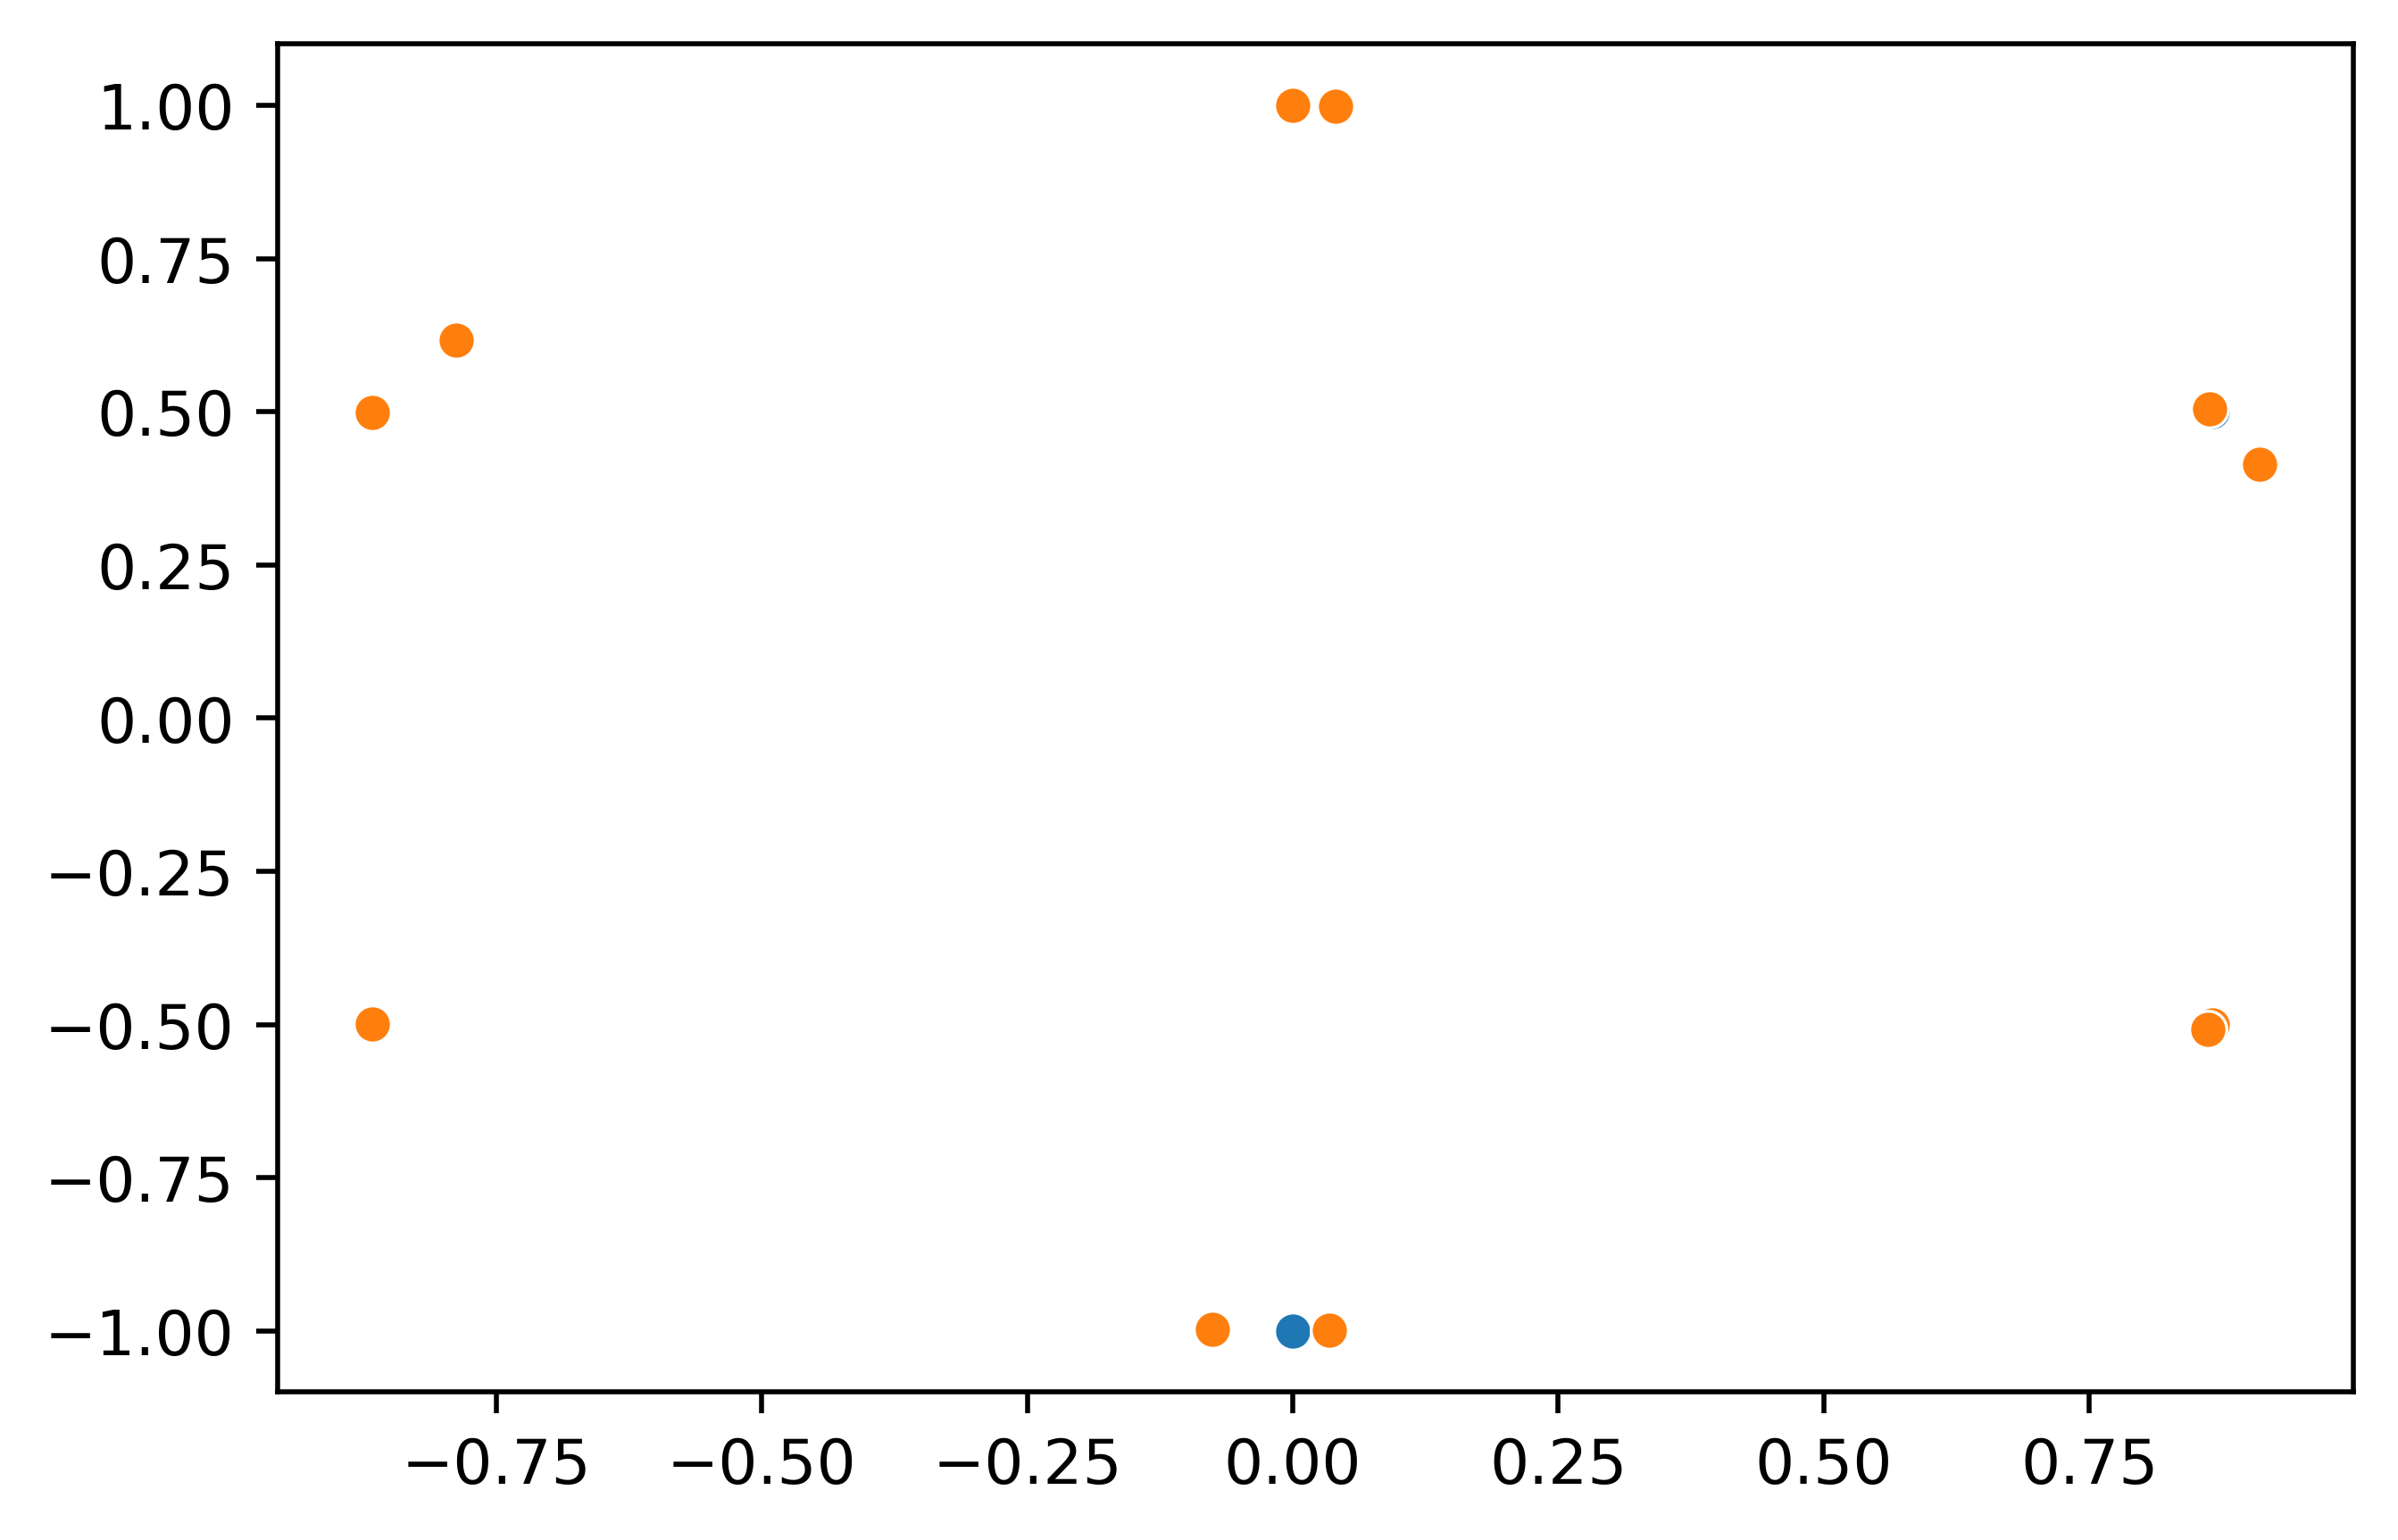

C:\Users\colmer\Anaconda3\envs\dota\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\colmer\Anaconda3\envs\dota\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


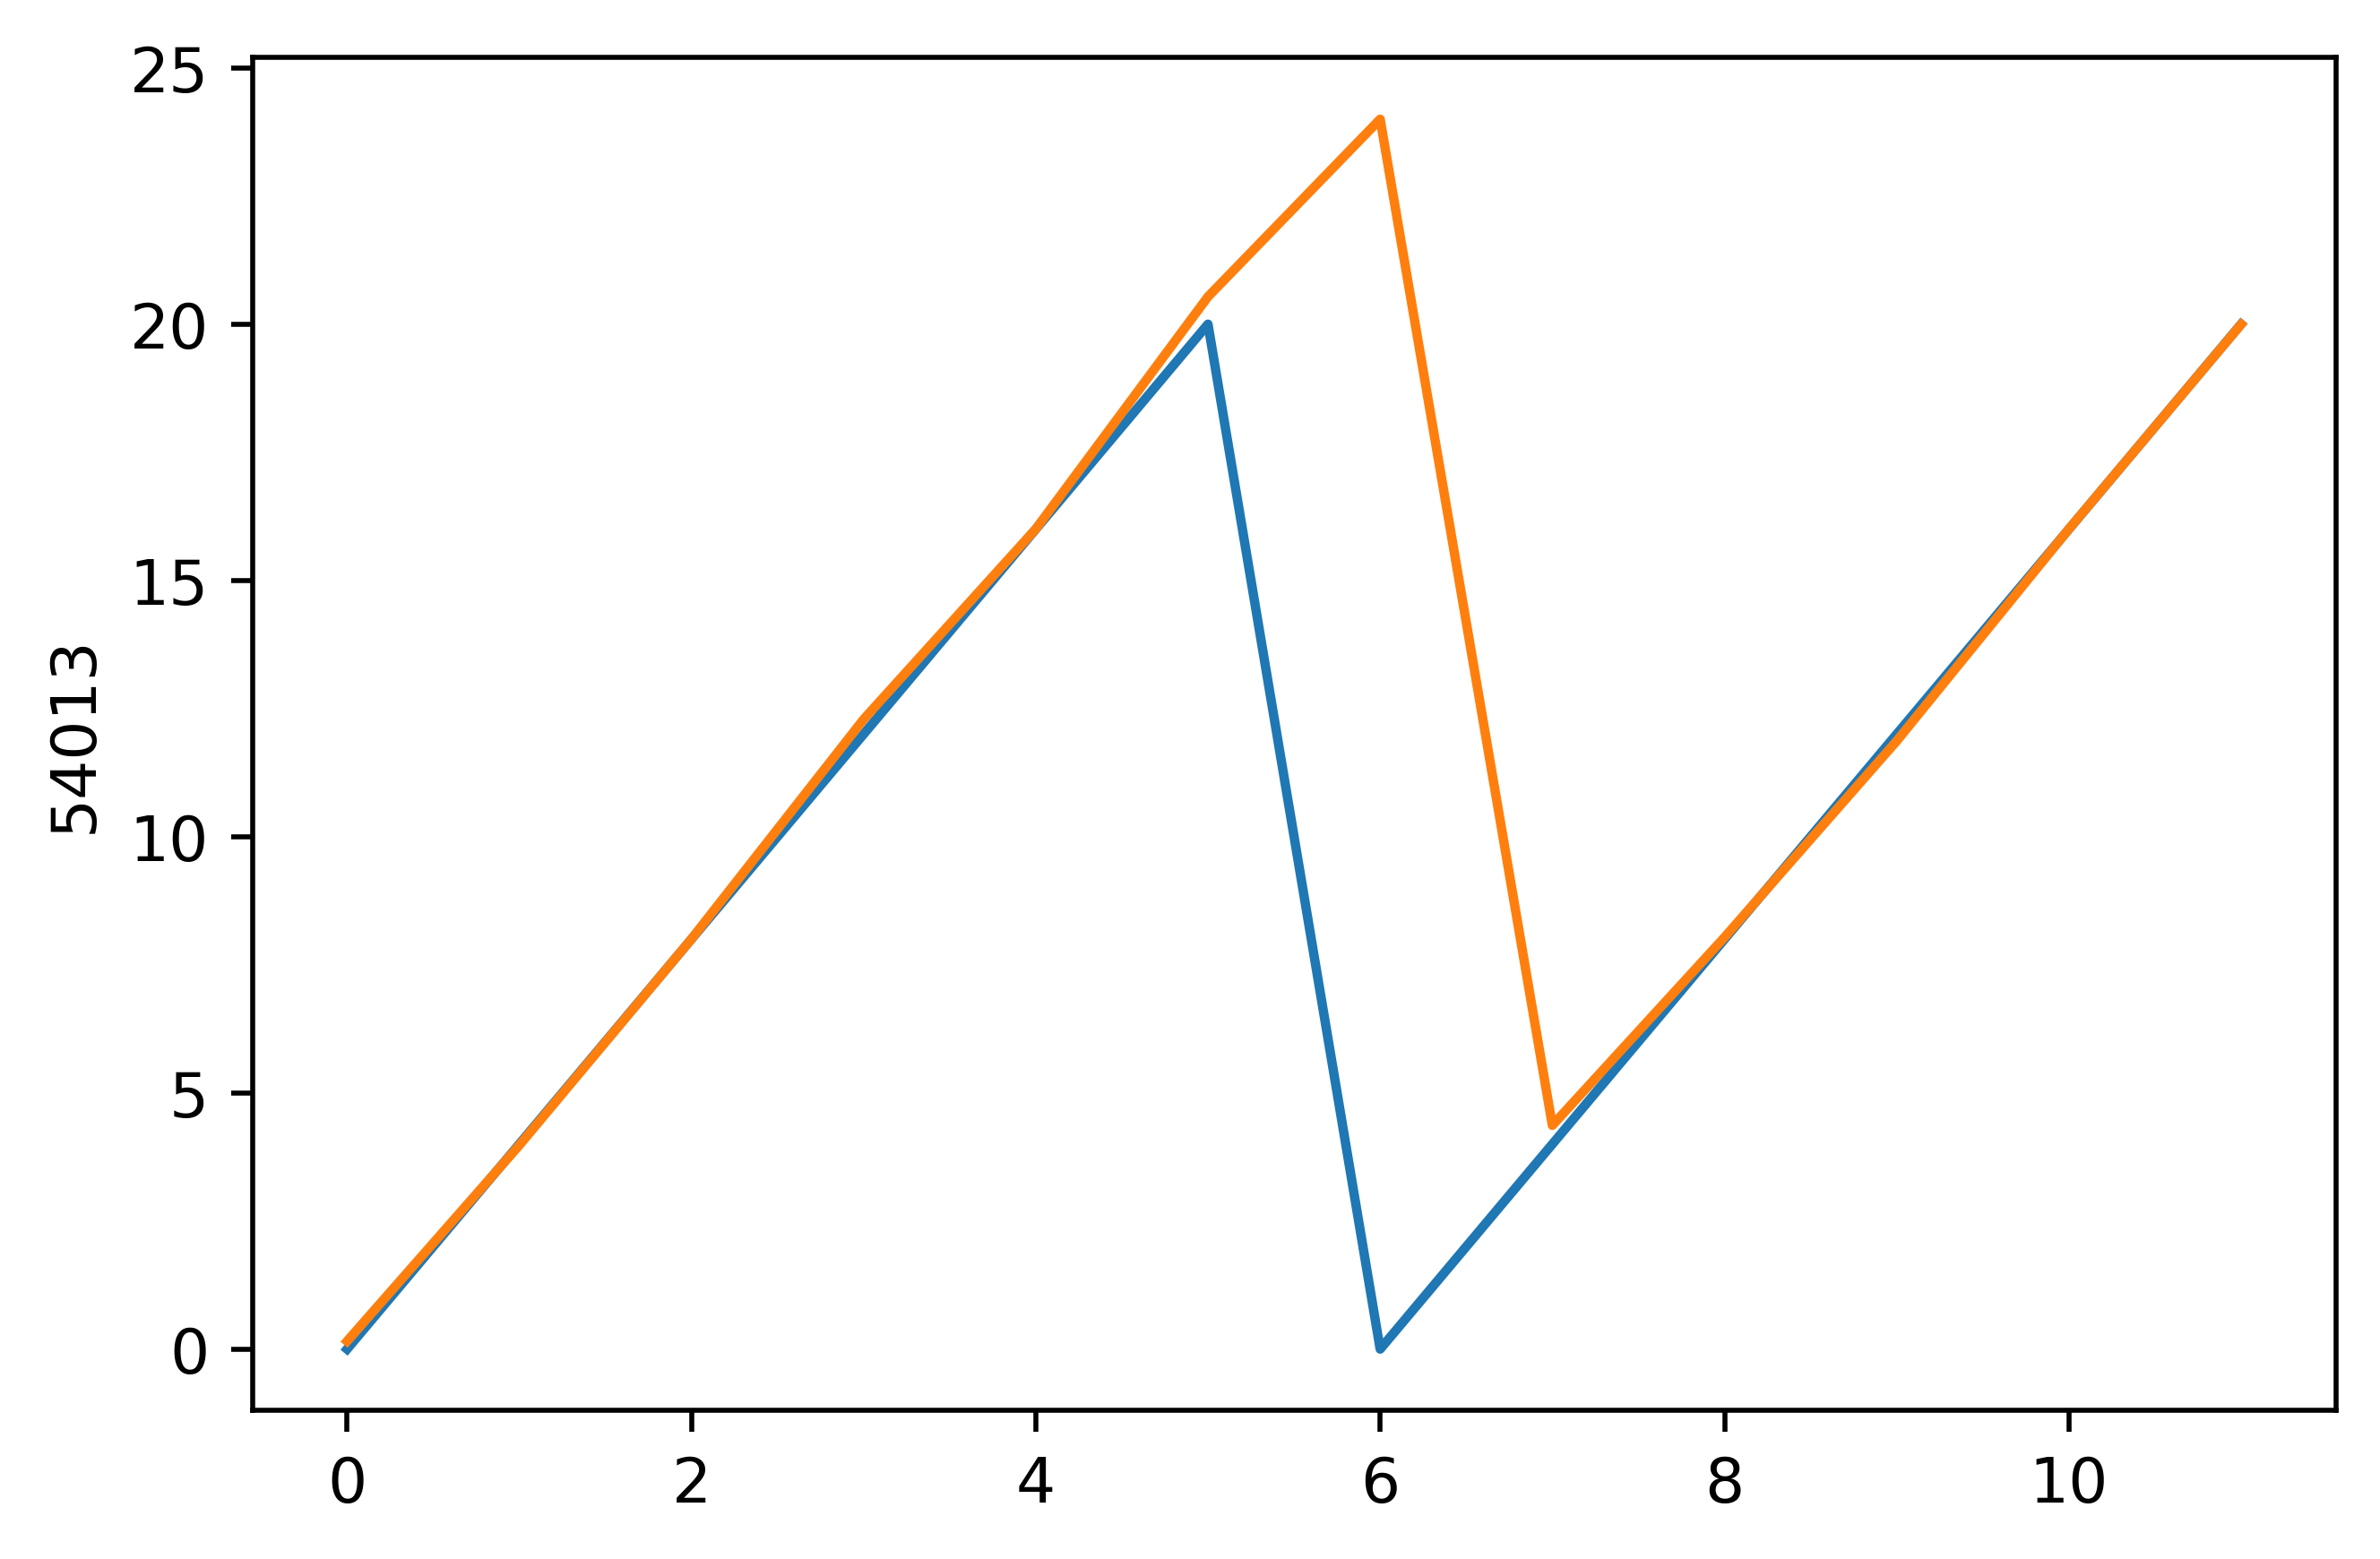

C:\Users\colmer\Anaconda3\envs\dota\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\colmer\Anaconda3\envs\dota\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


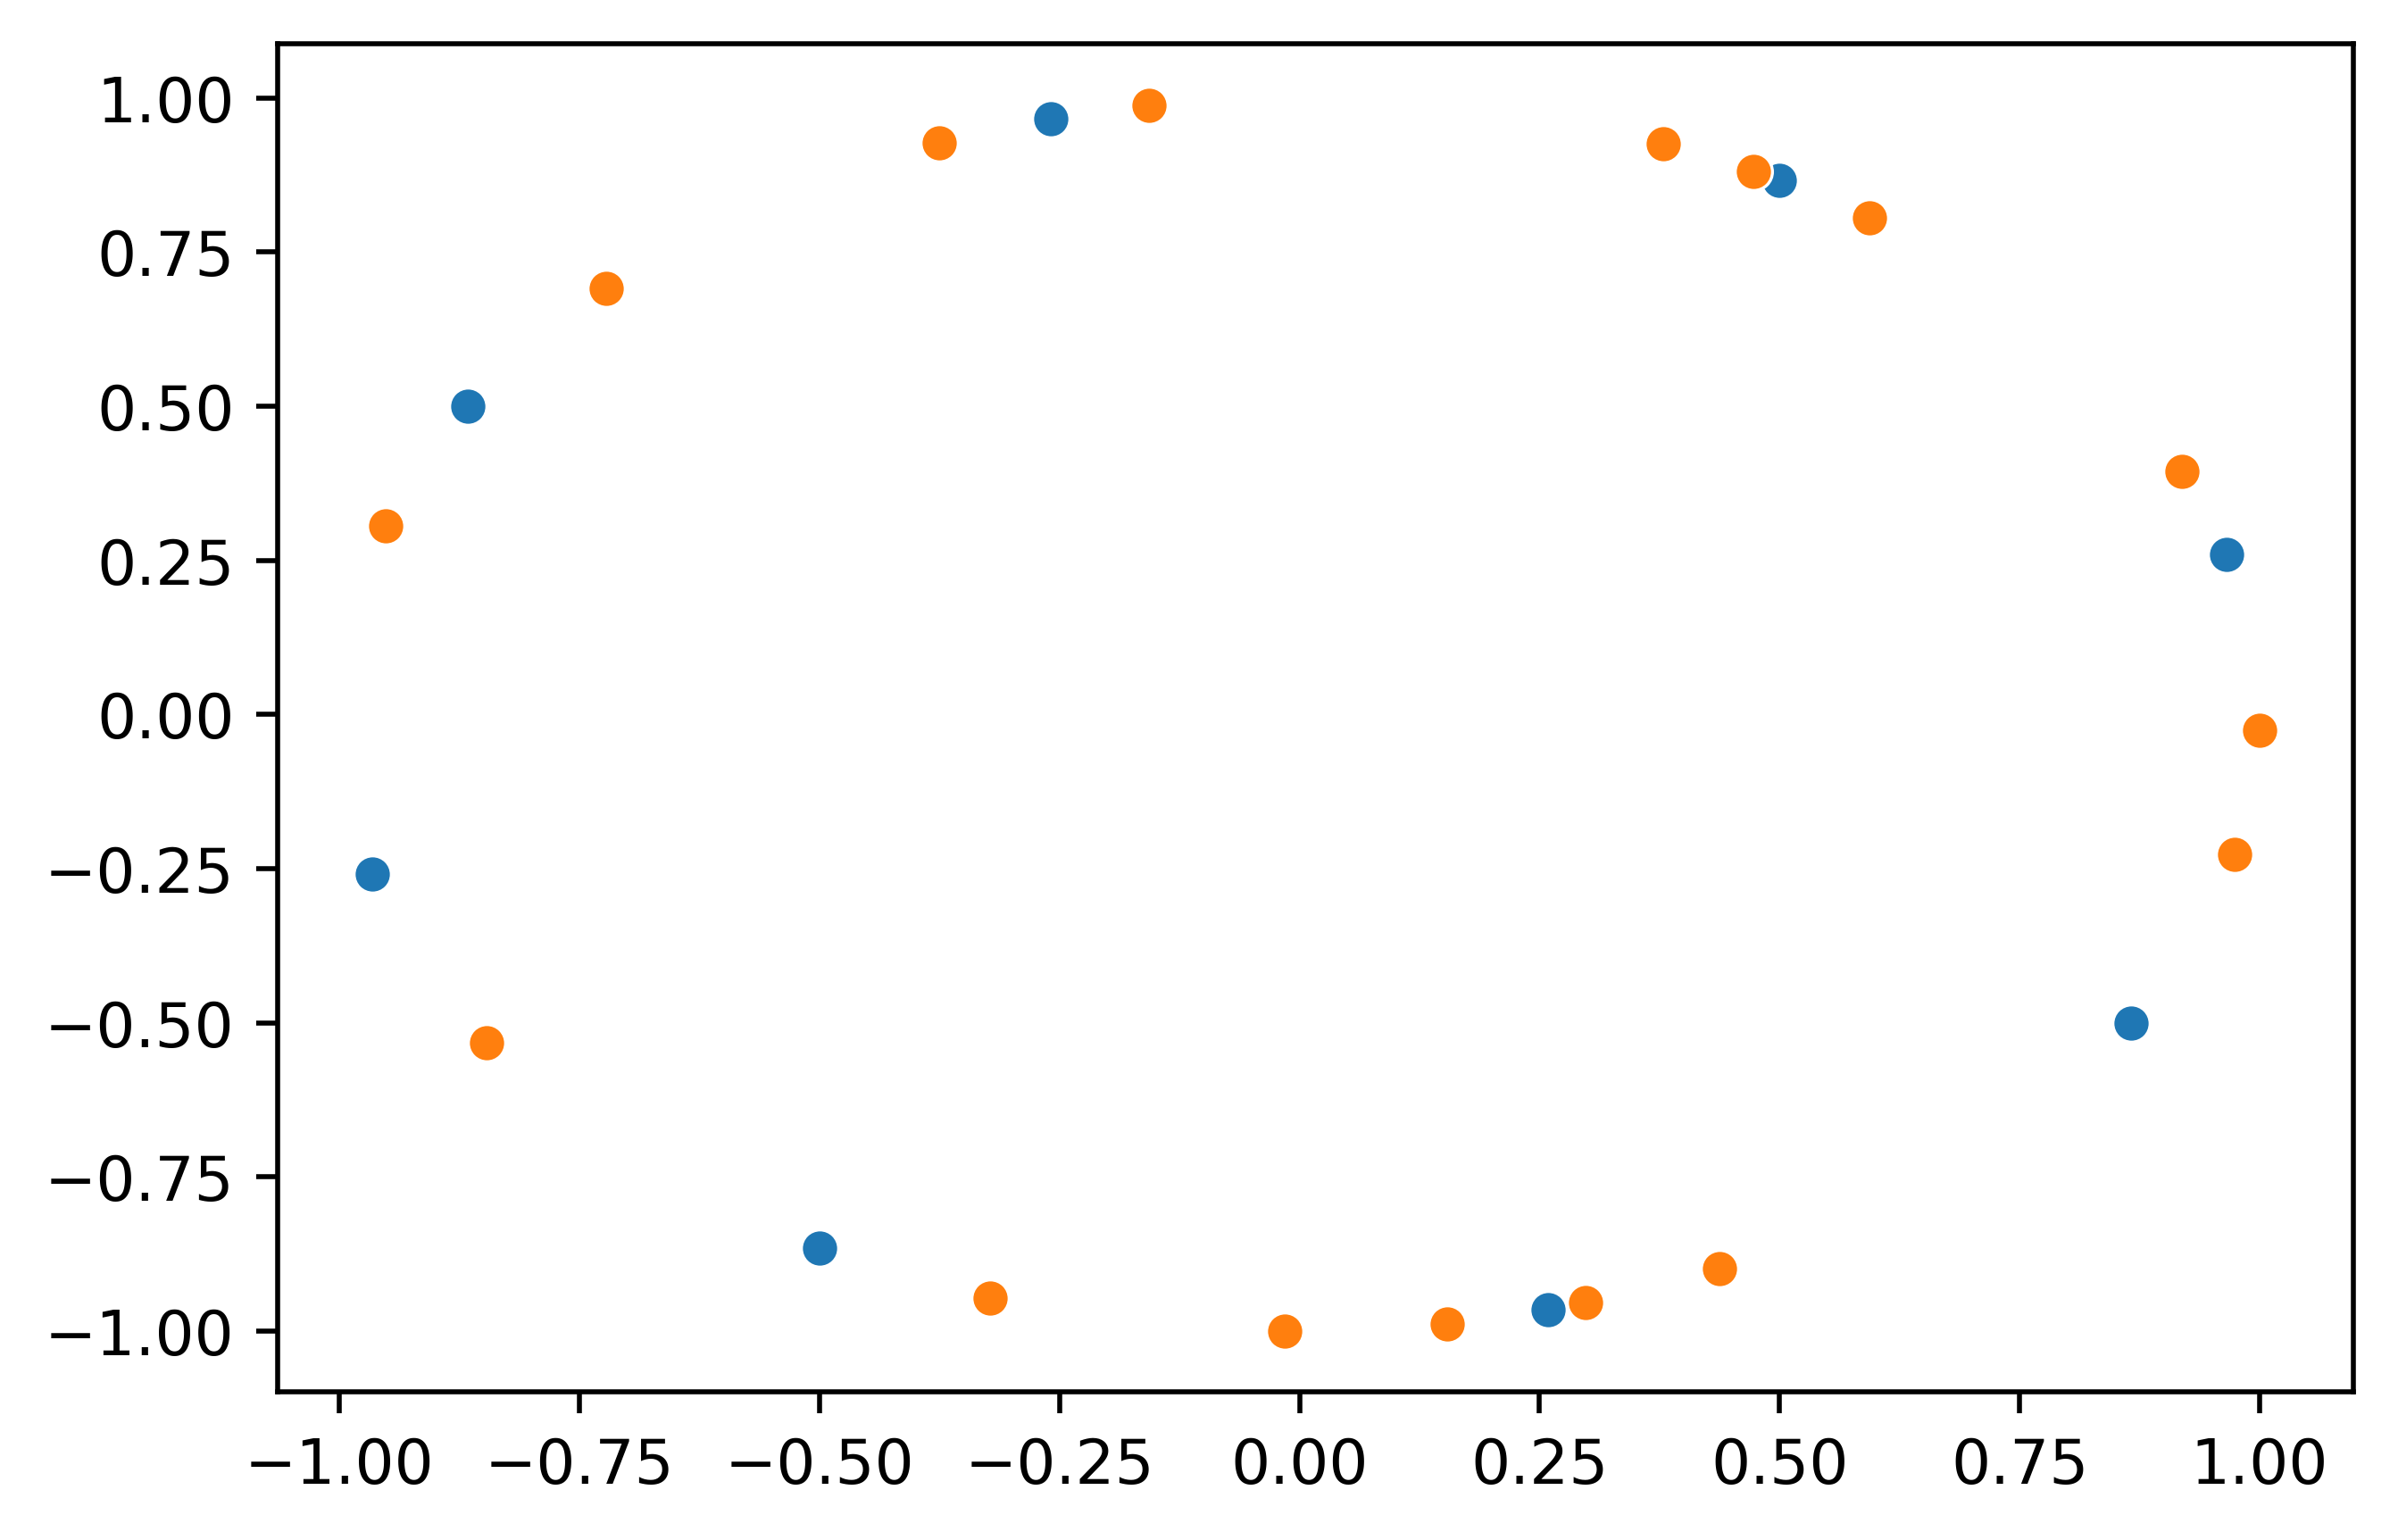

C:\Users\colmer\Anaconda3\envs\dota\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\colmer\Anaconda3\envs\dota\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


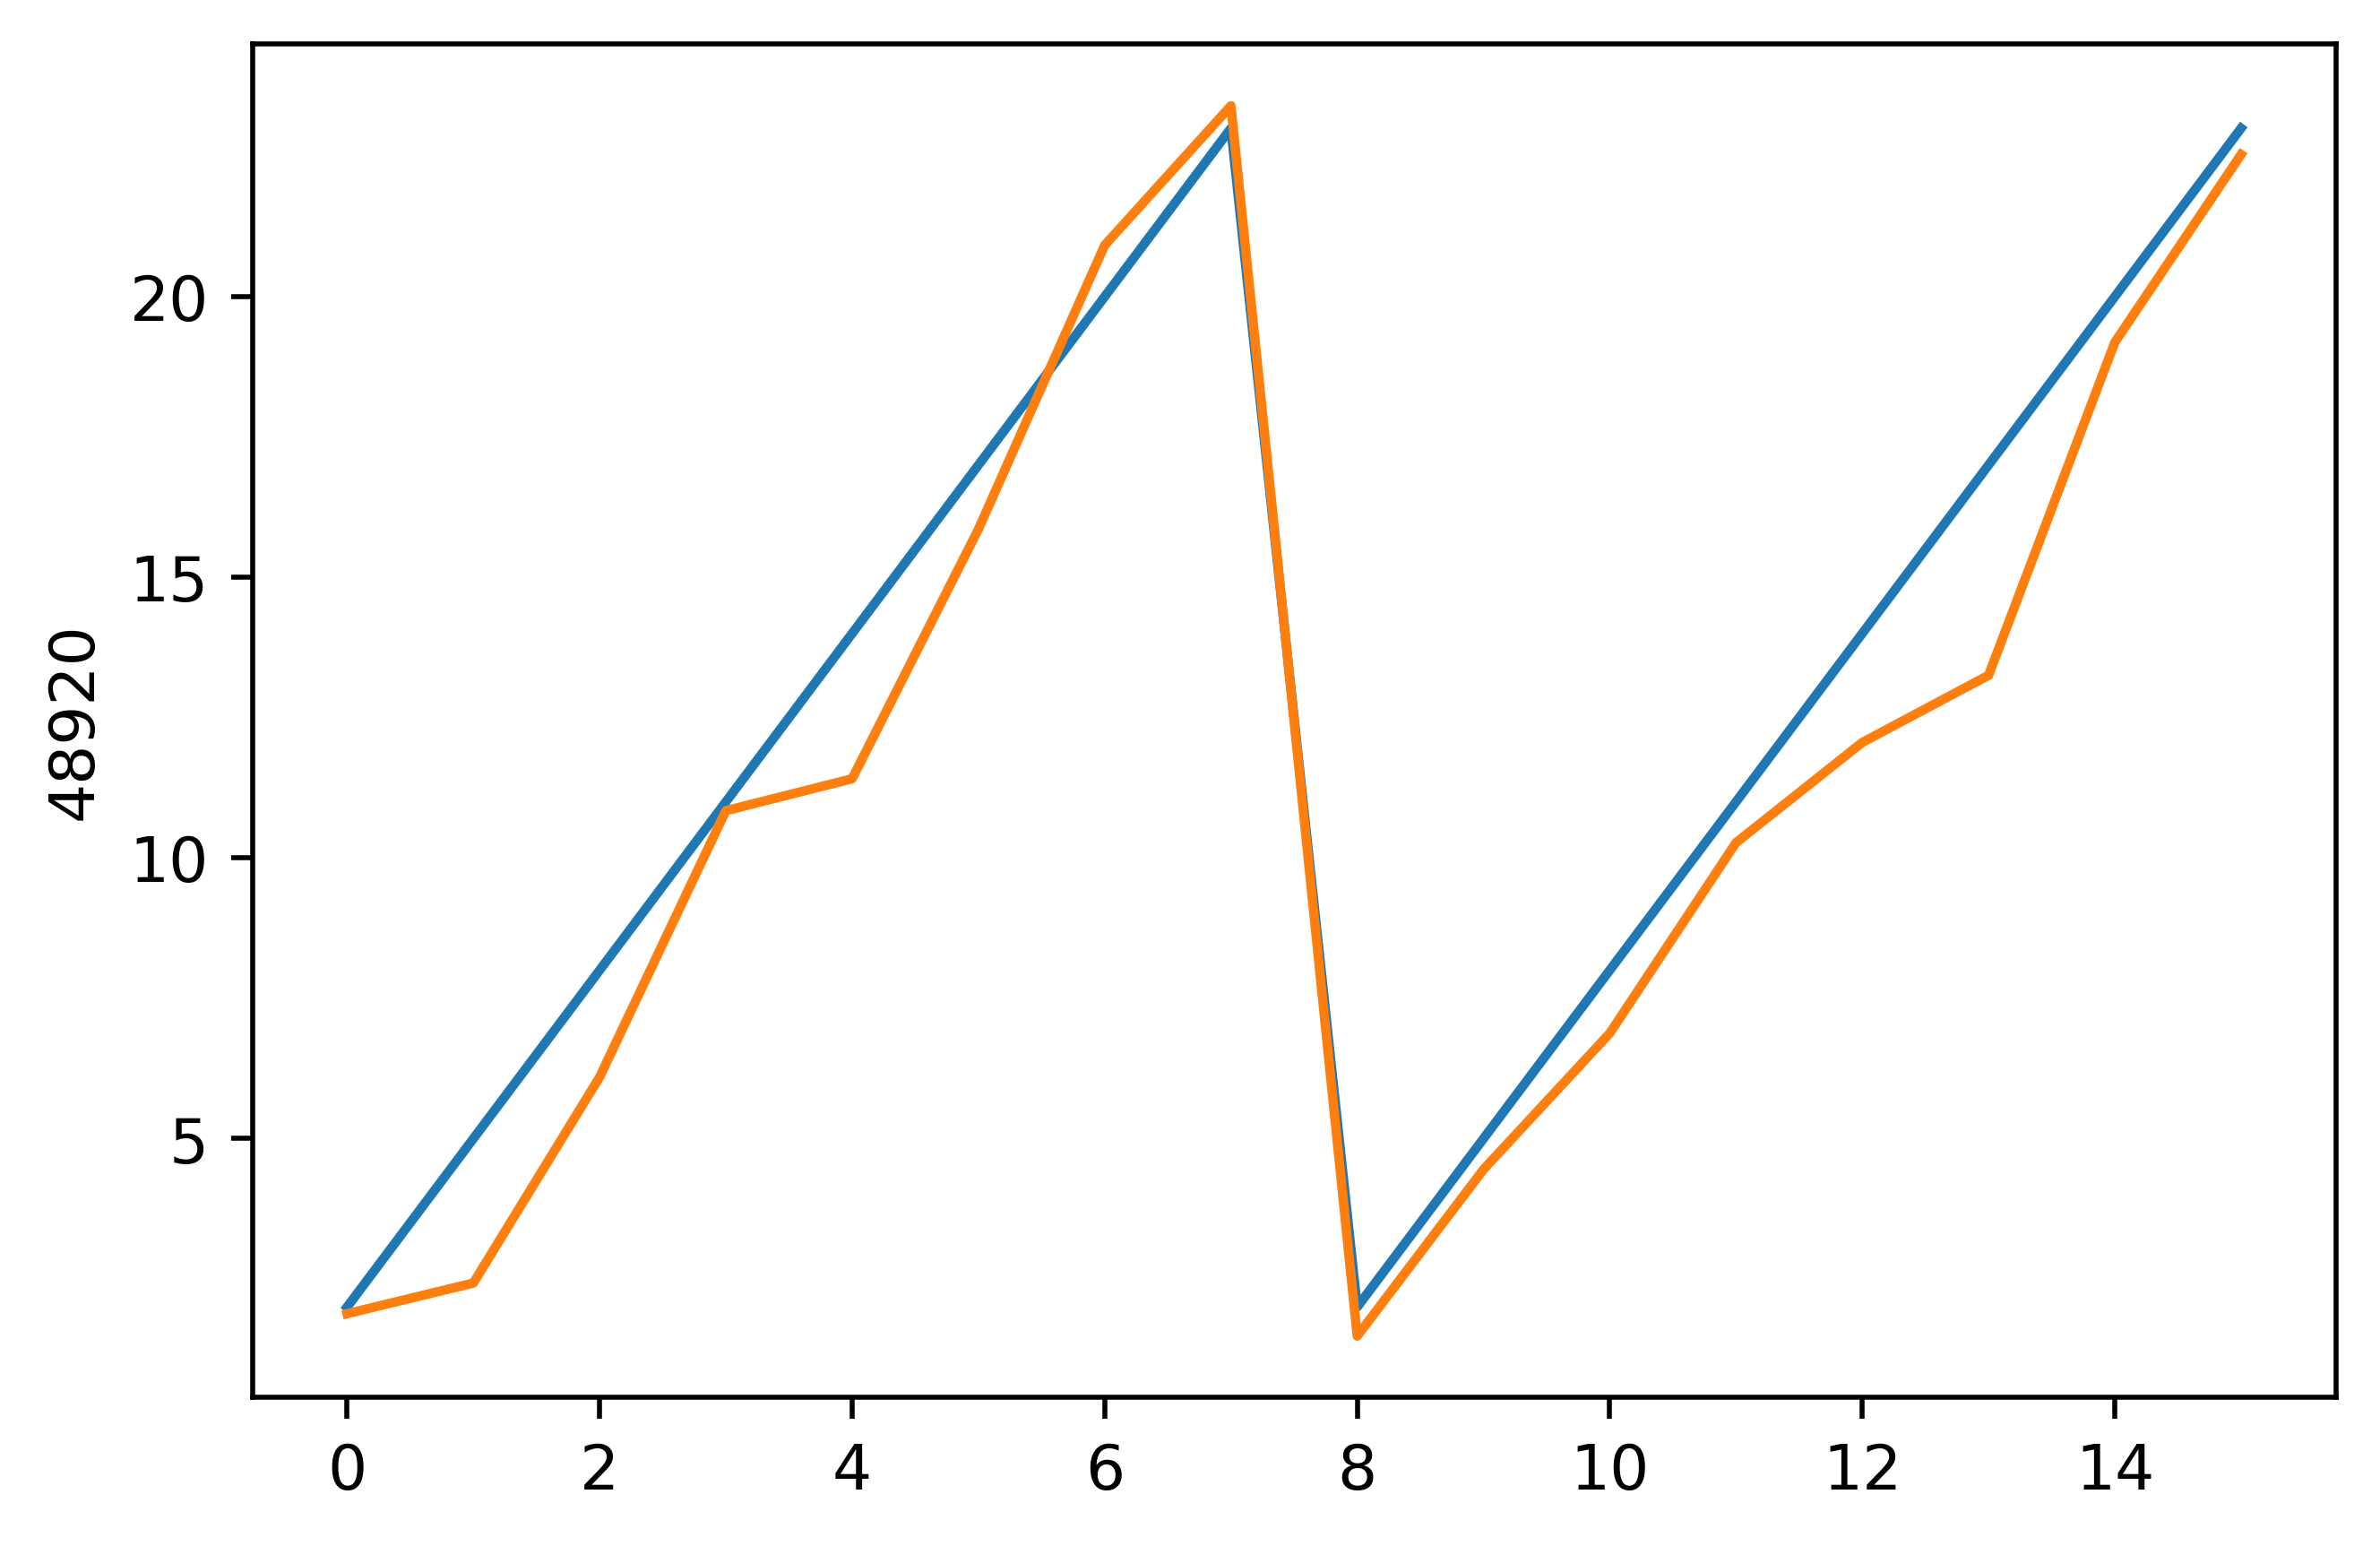

Average training error = 7.752380150292506 minutes
Average validation error = 73.82027952978636 minutes
Average test error = 168.48180602851346 minutes
black        8
turquoise    8
blue         8
None         8
red          8
green        8
brown        8
pink         8
yellow       8
Name: moduleColor, dtype: int64


In [7]:
# Collect and print results, plot predictions with respect to ground truth
angles = []
for i in range(all_preds.shape[0]):
    angles.append(math.atan2(all_preds[i, 0], all_preds[i, 1]) / math.pi * 12)

for j in range(len(angles)):
    if angles[j] < 0:
        angles[j] = angles[j] + 24

plt.figure(dpi=500)
ax = sn.scatterplot(Y_data[:, 0], Y_data[:, 1])
ax = sn.scatterplot(all_preds[:, 0], all_preds[:, 1])
plt.show()
angles_arr = np.vstack(angles)
hour_pred = angles_arr

plt.figure(dpi=500)
ax = sn.lineplot(np.arange(Y_copy.shape[0]), Y_copy)
ax = sn.lineplot(np.arange(Y_copy.shape[0]), angles_arr.ravel())
plt.show()


angles = []
for i in range(all_preds.shape[0]):
    angles.append(math.atan2(all_preds[i, 0], all_preds[i, 1]) / math.pi * 12)

for j in range(len(angles)):
    if angles[j] < 0:
        angles[j] = angles[j] + 24


valid_angles = []
valid_preds = np.mean(valid_preds, axis=0)
for i in range(valid_preds.shape[0]):
    valid_angles.append(math.atan2(valid_preds[i, 0], valid_preds[i, 1]) / math.pi * 12)

for j in range(len(valid_angles)):
    if valid_angles[j] < 0:
        valid_angles[j] = valid_angles[j] + 24
valid_preds = normalize(valid_preds)
plt.figure(dpi=500)
ax = sn.scatterplot(Y_valid_data[:, 0], Y_valid_data[:, 1])
ax = sn.scatterplot(valid_preds[:, 0], valid_preds[:, 1])
plt.show()
angles_arr_valid = np.vstack(valid_angles)
hour_pred_valid = angles_arr_valid


plt.figure(dpi=500)
ax = sn.lineplot(np.arange(Y_valid_copy.shape[0]), Y_valid_copy)
ax = sn.lineplot(np.arange(Y_valid_copy.shape[0]), angles_arr_valid.ravel())
plt.show()

print("Average training error = {} minutes".format(60 * 12 * cyclical_loss(Y_data.astype('float64'), all_preds.astype('float64')) / (Y_data.shape[0] * np.pi)))

print("Average validation error = {} minutes".format(60 * 12 * cyclical_loss(Y_valid_data.astype('float64'), valid_preds.astype('float64')) / (Y_valid_data.shape[0] * np.pi)))

Y_copy1 = np.array([2, 5, 8, 11, 14, 17, 20, 23, 2, 5, 8, 11, 14, 17, 20, 23])

test_angles = []
test_preds_copy = test_preds
test_preds = np.mean(test_preds, axis=0)
for j in range(len(test_preds_copy)):
    for i in range(test_preds.shape[0]):
        test_preds_copy[j][i, 0] = math.atan2(test_preds_copy[j][i, 0], test_preds_copy[j][i, 1]) / math.pi * 12
        if test_preds_copy[j][i, 0] < 0:
            test_preds_copy[j][i, 0] += 24
    test_preds_copy[j] = np.delete(test_preds_copy[j], 1, 1)

for i in range(test_preds.shape[0]):
    test_angles.append(math.atan2(test_preds[i, 0], test_preds[i, 1]) / math.pi * 12)
for j in range(len(test_angles)):
    if test_angles[j] < 0:
        test_angles[j] = test_angles[j] + 24
test_preds = normalize(test_preds)
angles_arr_test = np.vstack(test_angles)
hour_pred_test = angles_arr_test
Y_test = np.array([12, 0, 12, 0])

Y_test_cos = -np.cos((2 * np.pi * Y_test.astype('float64') / 24) + (np.pi / 2))
Y_test_sin = np.sin((2 * np.pi * Y_test.astype('float64') / 24) + (np.pi / 2))
Y_test_ang = np.concatenate((Y_test_cos.reshape(-1, 1), Y_test_sin.reshape(-1, 1)), axis=1)
print("Average test error = {} minutes".format(60 * 12 * cyclical_loss(Y_test_ang.astype('float64'), test_preds.astype('float64')) / (Y_test_ang.shape[0] * np.pi)))
val_errors1.append(60 * 12 * cyclical_loss(Y_valid_data.astype('float64'), all_valid_preds.astype('float64')) / (Y_valid_data.shape[0] * np.pi))
test_errors1.append(60 * 12 * cyclical_loss(Y_test_ang.astype('float64'), test_preds.astype('float64')) / (Y_test_ang.shape[0] * np.pi))

print(cluster_score_df['moduleColor'].value_counts())